# Hyperparameter tuning by grid-search

In the previous notebook, we saw that hyperparameters can affect the statistical performance of a model. In this notebook, we will show how to optimize hyperparameters using a grid-search approach.

## Our predictive model

In [2]:
from sklearn import set_config

set_config(display="diagram")

In [3]:
import pandas as pd

In [4]:
adult_census = pd.read_csv("data/adult-census.csv")

target_name = "class"
target = adult_census[target_name]
target

0         <=50K
1         <=50K
2          >50K
3          >50K
4         <=50K
          ...  
48837     <=50K
48838      >50K
48839     <=50K
48840     <=50K
48841      >50K
Name: class, Length: 48842, dtype: object

In [5]:
data = adult_census.drop(columns=[target_name, "education-num"])
data.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,103497,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42)

In [8]:
from sklearn.compose import make_column_selector as selector

In [9]:
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

In [10]:
from sklearn.preprocessing import OrdinalEncoder

In [11]:
categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

In [12]:
from sklearn.compose import ColumnTransformer

In [13]:
preprocessor = ColumnTransformer([
    ("cat-preprocessor", categorical_preprocessor, categorical_columns)],
    remainder="passthrough", sparse_threshold=0)

In [14]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

In [15]:
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", 
     HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4))])
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat-preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

## Tuning using a grid-search

In [16]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__learning_rate': (0.05, 0.1, 0.5, 1, 5),
    'classifier__max_leaf_nodes': (3, 10, 30, 100)}
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                n_jobs=2, cv=2)
model_grid_search.fit(data_train, target_train)

Wall time: 25.1 s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat-preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'native-country'])])),
                                       ('classifier',
                                        HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                                       random_state=42))]),
             n_jobs=2,
             param_grid={'classifier__learning_rate': (0.05, 0.1, 0.5, 1, 5),
                         'classifier__max_leaf_nodes': (3, 10, 30, 100)})

In [17]:
accuracy = model_grid_search.score(data_test, target_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}")

The test accuracy score of the grid-searched pipeline is: 0.88


In [18]:
model_grid_search.predict(data_test.iloc[0:5])

array([' <=50K', ' <=50K', ' >50K', ' <=50K', ' >50K'], dtype=object)

In [19]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 30}


In [20]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
6,1.257139,0.054354,0.246341,0.025931,0.1,30,"{'classifier__learning_rate': 0.1, 'classifier...",0.867766,0.867649,0.867708,0.000058,1
2,1.595235,0.012467,0.239360,0.002992,0.05,30,"{'classifier__learning_rate': 0.05, 'classifie...",0.867220,0.866557,0.866889,0.000331,2
5,0.718578,0.000500,0.234373,0.008975,0.1,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.866729,0.866557,0.866643,0.000086,3
9,0.339093,0.022938,0.193482,0.045878,0.5,10,"{'classifier__learning_rate': 0.5, 'classifier...",0.865855,0.866121,0.865988,0.000133,4
3,4.542353,0.005487,0.269778,0.011469,0.05,100,"{'classifier__learning_rate': 0.05, 'classifie...",0.866456,0.865029,0.865742,0.000713,5


In [21]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [22]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,learning_rate,max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
6,0.1,30,0.867708,0.000058,1
2,0.05,30,0.866889,0.000331,2
5,0.1,10,0.866643,0.000086,3
9,0.5,10,0.865988,0.000133,4
3,0.05,100,0.865742,0.000713,5
7,0.1,100,0.865469,0.001096,6
8,0.5,3,0.865305,0.000815,7
10,0.5,30,0.864377,0.001150,8
1,0.05,10,0.861756,0.000105,9
12,1,3,0.860910,0.000351,10


In [23]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["learning_rate"],
    columns=["max_leaf_nodes"])

pivoted_cv_results

max_leaf_nodes,3,10,30,100
learning_rate,,,,
0.05,0.827196,0.861756,0.866889,0.865742
0.10,0.853512,0.866643,0.867708,0.865469
0.50,0.865305,0.865988,0.864377,0.854795
1.00,0.860910,0.859927,0.851547,0.831809
5.00,0.283476,0.527581,0.618380,0.544130


In [24]:
import seaborn as sns

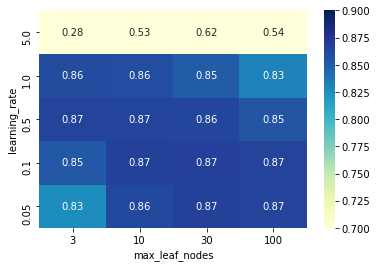

In [25]:
ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7,
                 vmax=0.9)
ax.invert_yaxis()

In this notebook we have seen:

* how to optimize the hyperparameters of a predictive model via a
  grid-search;
* that searching for more than two hyperparamters is too costly;
* that a grid-search does not necessarily find an optimal solution.